In [70]:

import numpy as np
import pandas as pd




'''
from scipy.stats import skew, norm


from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, cross_val_score

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
'''

pd.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings(action="ignore")
pd.options.display.max_seq_items = 8000
pd.options.display.max_rows = 8000



**Pull data from file to dataframes**

In [71]:
import pandas as pd
import numpy as np

train_path = 'Data/train.csv'
test_path = 'Data/test.csv'

train = pd.read_csv(train_path)
test = pd.read_csv(test_path)

train.shape, test.shape

((1460, 81), (1459, 80))

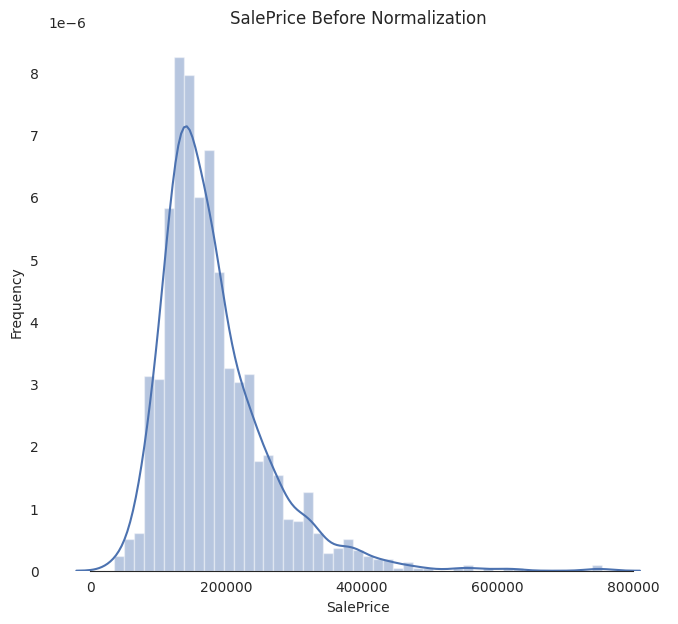

In [72]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("white")
sns.set_color_codes(palette='deep')
f, ax = plt.subplots(figsize=(8, 7))
ax.set(ylabel="Frequency")
ax.set(xlabel="SalePrice")
ax.set(title="SalePrice Before Normalization")
ax.xaxis.grid(False)

sns.distplot(train['SalePrice'], color="b");
sns.despine(trim=True, left=True)

plt.show()

Normalize SalePrice values so they work better with some of the models we're using

In [73]:
train["SalePrice"] = np.log1p(train["SalePrice"])


 mu = 12.02 and sigma = 0.40



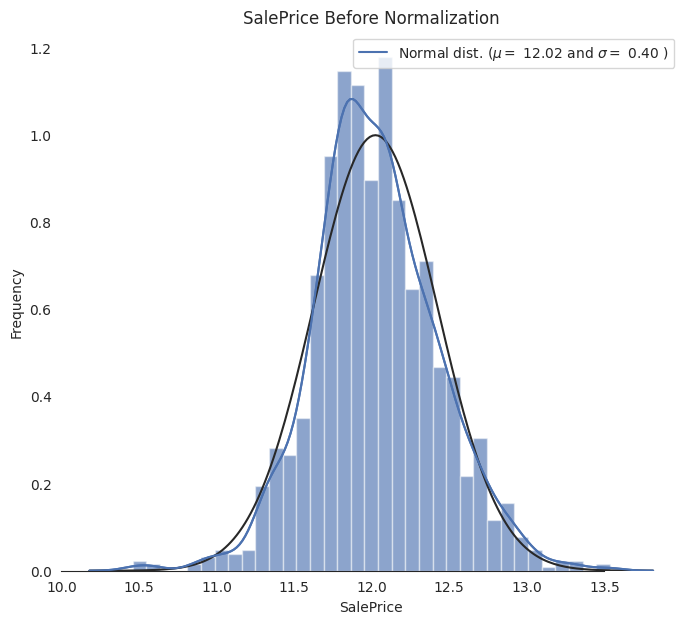

In [74]:
from scipy.stats import skew, norm

sns.set_style("white")
sns.set_color_codes(palette='deep')
f, ax = plt.subplots(figsize=(8, 7))
#Check the new distribution 
sns.distplot(train['SalePrice'] , fit=norm, color="b");

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Replot
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
sns.set_style("white")
sns.set_color_codes(palette='deep')
ax.set(ylabel="Frequency")
ax.set(xlabel="SalePrice")
ax.set(title="SalePrice Before Normalization")
ax.xaxis.grid(False)

sns.distplot(train['SalePrice'], color="b");
sns.despine(trim=True, left=True)

plt.show()


create "numeric_features", a list of all features that are already numeric

In [75]:
numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric_features = []
for i in train.columns:
    if train[i].dtype in numeric_dtypes:
        if i in ['TotalSF', 'Total_Bathrooms','Total_porch_sf','haspool','hasgarage','hasbsmt','hasfireplace']:
            pass
        else:
            numeric_features.append(i)    
len(numeric_features)

38

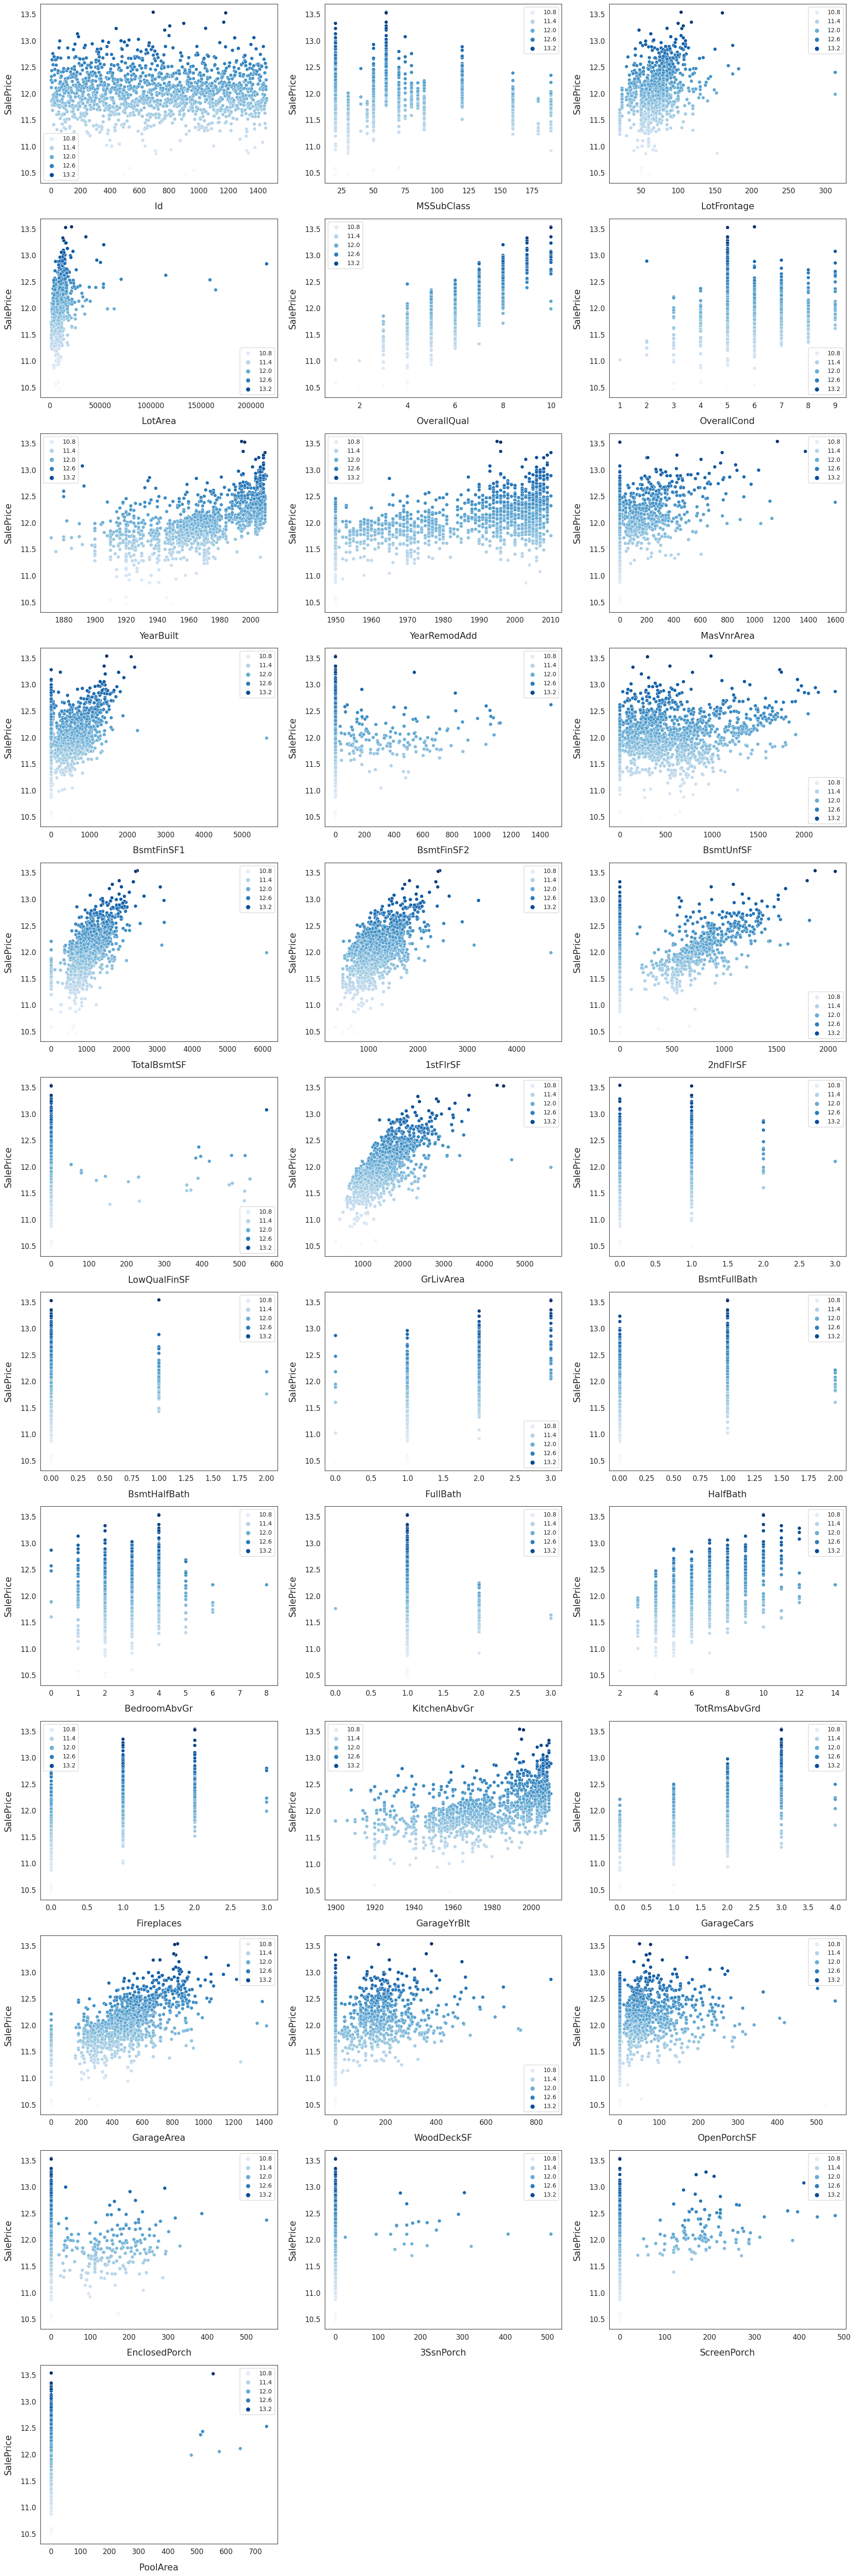

In [76]:
fig, axs = plt.subplots(ncols=3, figsize=(10, 100))
sns.color_palette("husl", 8)
plt.subplots_adjust(right=2)
plt.subplots_adjust(top=2)


for i, feature in enumerate(list(train[numeric_features]), 1):
    if(feature=='MiscVal'):
        break
    plt.subplot(len(list(numeric_features)), 3, i)
    sns.scatterplot(x=feature, y='SalePrice', hue='SalePrice', palette='Blues', data=train)
        
    plt.xlabel('{}'.format(feature), size=15,labelpad=12.5)
    plt.ylabel('SalePrice', size=15, labelpad=12.5)
    
    for j in range(2):
        plt.tick_params(axis='x', labelsize=12)
        plt.tick_params(axis='y', labelsize=12)
    
    plt.legend(loc='best', prop={'size': 10})
        
plt.show()

In [77]:
train_ID = train['Id']
test_ID = test['Id']
train.drop(['Id'], axis=1, inplace=True)
test.drop(['Id'], axis=1, inplace=True)

In [78]:
train_labels = train['SalePrice'].reset_index(drop=True)
train_features = train.drop(['SalePrice'], axis=1)
test_features = test

# We're transforming the features in the dataset, and need to do so with both train and test features
all_features = pd.concat([train_features, test_features]).reset_index(drop=True)
all_features.shape

(2919, 79)

Check missing values

In [79]:

data = pd.DataFrame(all_features)
df_cols = list(pd.DataFrame(data))
missing = {}
for i in range(0, len(df_cols)):
    missing.update({df_cols[i]: round(data[df_cols[i]].isnull().mean()*100,2)})

df_miss = sorted(missing.items(), key=lambda x: x[1], reverse=True)
print('Columns with the most missing data')
df_miss[0:10]

Columns with the most missing data


[('PoolQC', 99.66),
 ('MiscFeature', 96.4),
 ('Alley', 93.22),
 ('Fence', 80.44),
 ('MasVnrType', 60.5),
 ('FireplaceQu', 48.65),
 ('LotFrontage', 16.65),
 ('GarageYrBlt', 5.45),
 ('GarageFinish', 5.45),
 ('GarageQual', 5.45)]

In [80]:
all_features['MSSubClass'] = all_features['MSSubClass'].apply(str)
all_features['YrSold'] = all_features['YrSold'].astype(str)
all_features['MoSold'] = all_features['MoSold'].astype(str)

In [81]:

#Missing data from these features is replaced by their arithmetic mode
all_features['MSZoning'] = all_features.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))
all_features['Exterior2nd'] = all_features['Exterior2nd'].fillna(all_features['Exterior2nd'].mode()[0])
all_features['KitchenQual'] = all_features['KitchenQual'].fillna("TA")
all_features['Exterior1st'] = all_features['Exterior1st'].fillna(all_features['Exterior1st'].mode()[0])
all_features['Electrical'] = all_features['Electrical'].fillna("SBrkr")
all_features['SaleType'] = all_features['SaleType'].fillna(all_features['SaleType'].mode()[0])

# missing values for these features are replaced by specific values outlined in data_description.txt
all_features['Functional'] = all_features['Functional'].fillna('Typ')
all_features['PoolQC'] = all_features["PoolQC"].fillna("None")
all_features['LotFrontage'] = all_features.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_features[col] = all_features[col].fillna('None')
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    all_features[col] = all_features[col].fillna(0)
for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
    all_features[col] = all_features[col].fillna('None')

# The remaining features are replaced with a default value 'None'
objects = []
for i in all_features.columns:
    if all_features[i].dtype == object:
        objects.append(i)
all_features.update(all_features[objects].fillna('None'))
    
# Similar for the numeric features
numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric = []
for i in all_features.columns:
    if all_features[i].dtype in numeric_dtypes:
        numeric.append(i)
all_features.update(all_features[numeric].fillna(0))    

In [82]:
data = pd.DataFrame(all_features)
df_cols = list(pd.DataFrame(data))
missing = {}
for i in range(0, len(df_cols)):
    missing.update({df_cols[i]: round(data[df_cols[i]].isnull().mean()*100,2)})
    
df_miss = sorted(missing.items(), key=lambda x: x[1], reverse=True)
print('Percent of missing data')
df_miss[0:10]

Percent of missing data


[('MSSubClass', 0.0),
 ('MSZoning', 0.0),
 ('LotFrontage', 0.0),
 ('LotArea', 0.0),
 ('Street', 0.0),
 ('Alley', 0.0),
 ('LotShape', 0.0),
 ('LandContour', 0.0),
 ('Utilities', 0.0),
 ('LotConfig', 0.0)]

In [83]:
# Fetch all numeric features
numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric = []
for i in all_features.columns:
    if all_features[i].dtype in numeric_dtypes:
        numeric.append(i)

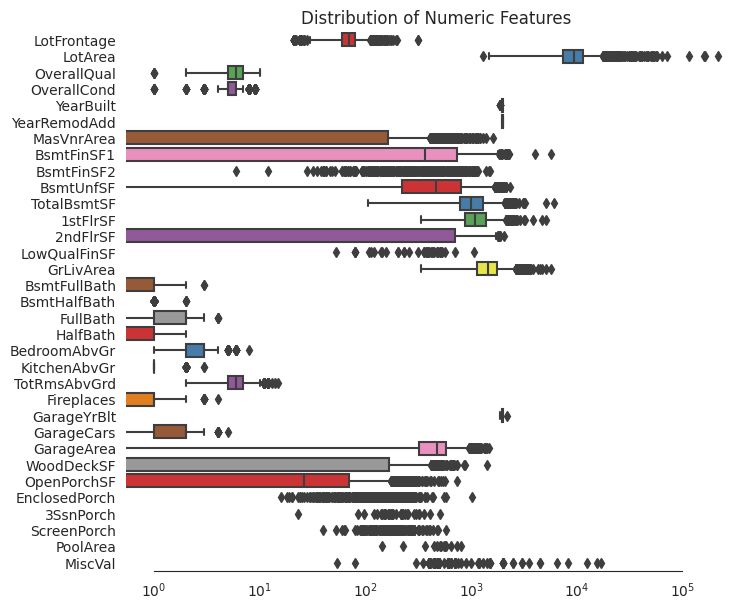

In [84]:

sns.set_style("white")
f, ax = plt.subplots(figsize=(8, 7))
ax.set_xscale("log")
ax = sns.boxplot(data=all_features[numeric] , orient="h", palette="Set1")
ax.xaxis.grid(False)
ax.set(title="Distribution of Numeric Features")

sns.despine(trim=True, left=True)

In [85]:
# Find skewed numerical features
skew_features = all_features[numeric].apply(lambda x: skew(x)).sort_values(ascending=False)

high_skew = skew_features[skew_features > 0.5]
skew_index = high_skew.index

print("There are {} numerical features with Skew > 0.5 :".format(high_skew.shape[0]))
skewness = pd.DataFrame({'Skew' :high_skew})
skew_features.head(10)

There are 25 numerical features with Skew > 0.5 :


MiscVal          21.947195
PoolArea         16.898328
LotArea          12.822431
LowQualFinSF     12.088761
3SsnPorch        11.376065
KitchenAbvGr      4.302254
BsmtFinSF2        4.146143
EnclosedPorch     4.003891
ScreenPorch       3.946694
BsmtHalfBath      3.931594
dtype: float64

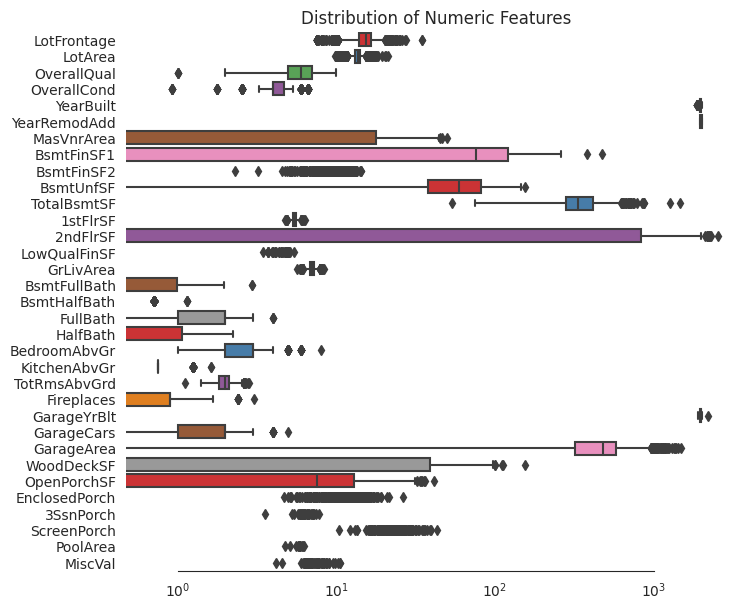

In [86]:
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

for i in skew_index:
    all_features[i] = boxcox1p(all_features[i], boxcox_normmax(all_features[i] + 1))

#replot
sns.set_style("white")
f, ax = plt.subplots(figsize=(8, 7))
ax = sns.boxplot(data=all_features[numeric] , orient="h", palette="Set1")
ax.xaxis.grid(False)
ax.set_xscale("log")
ax.set(title="Distribution of Numeric Features")

sns.despine(trim=True, left=True)

In [87]:
all_features = pd.get_dummies(all_features).reset_index(drop=True)
X = all_features.iloc[:len(train_labels), :]
X_test = all_features.iloc[len(train_labels):, :]
X.shape, train_labels.shape, X_test.shape

((1460, 333), (1460,), (1459, 333))

In [88]:
#split data 

from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X, train_labels, test_size=0.33, random_state=42, shuffle=True)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((978, 333), (482, 333), (978,), (482,))

In [89]:
# Regression Models

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

lr = LinearRegression()
knr = KNeighborsRegressor(n_neighbors=5)
dtr = DecisionTreeRegressor(max_depth=3)
rfr = RandomForestRegressor(n_estimators=100, random_state=42)
gbr = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)


In [90]:
#Feature Selection

#Variance threshold
from sklearn.feature_selection import VarianceThreshold

var = VarianceThreshold(threshold=0.1)
var.fit_transform(X, train_labels)

mask = var.get_support()

selected_columns_variance = X.columns[mask]
print("SELECTED COLUMNS BY VARIANCE THRESHOLD: " , selected_columns_variance)

X_train_subset_variance = X_train[selected_columns_variance]
X_test_subset_variance = X_valid[selected_columns_variance]


SELECTED COLUMNS BY VARIANCE THRESHOLD:  Index(['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', '2ndFlrSF', 'LowQualFinSF', 'BsmtFullBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'Fireplaces', 'GarageYrBlt', 'GarageCars',
       'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'MiscVal', 'MSSubClass_20', 'MSSubClass_60',
       'MSZoning_RL', 'MSZoning_RM', 'LotShape_IR1', 'LotShape_Reg',
       'LotConfig_Corner', 'LotConfig_Inside', 'Neighborhood_NAmes',
       'Condition1_Norm', 'BldgType_1Fam', 'HouseStyle_1Story',
       'HouseStyle_2Story', 'RoofStyle_Gable', 'RoofStyle_Hip',
       'Exterior1st_HdBoard', 'Exterior1st_MetalSd', 'Exterior1st_VinylSd',
       'Exterior1st_Wd Sdng', 'Exterior2nd_HdBoard', 'Exterior2nd_MetalSd',
       'Exterior2nd_VinylSd', 'Exterior2nd_Wd Sdng', 'MasVnrType_BrkFace

In [91]:
#Lasso 

from sklearn.linear_model import Lasso

model = Lasso(alpha=0.1)

# fit the model to the data
model.fit(X_train, y_train)

# get the selected feature indices
selected_features_lasso = model.coef_.nonzero()[0]
selected_features_lasso = X_train.columns[selected_features_lasso]
print("SELECTED COLUMNS BY LASSO: " , selected_features_lasso)

X_train_subset_lasso = X_train[selected_features_lasso]
X_test_subset_lasso = X_valid[selected_features_lasso]

SELECTED COLUMNS BY LASSO:  Index(['YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'TotalBsmtSF',
       '2ndFlrSF', 'GarageYrBlt', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'ScreenPorch'],
      dtype='object')


In [92]:
#RFE
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

rfe = RFE(lr, n_features_to_select=20)

# fit the RFE object to the data
rfe.fit(X_train, y_train)

# print the selected features
selected_features_rfe = rfe.get_support()
selected_features_rfe = X_train.columns[selected_features_rfe]
print("SELECTED COLUMNS BY RFE: " , selected_features_rfe)

X_train_subset_rfe = X_train[selected_features_rfe]
X_test_subset_rfe = X_valid[selected_features_rfe]

SELECTED COLUMNS BY RFE:  Index(['LotConfig_Corner', 'LotConfig_CulDSac', 'LotConfig_FR2',
       'LotConfig_FR3', 'LotConfig_Inside', 'LandSlope_Gtl', 'LandSlope_Mod',
       'LandSlope_Sev', 'ExterQual_Fa', 'BsmtCond_None', 'BsmtExposure_Av',
       'BsmtExposure_Gd', 'BsmtExposure_Mn', 'BsmtExposure_No',
       'BsmtExposure_None', 'HeatingQC_Ex', 'HeatingQC_Fa', 'HeatingQC_Gd',
       'HeatingQC_Po', 'HeatingQC_TA'],
      dtype='object')


In [93]:
#sfs with linear regression

from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LinearRegression

model = LinearRegression()

sfs = SequentialFeatureSelector(model, k_features=20, forward=True)

# fit the SFS model to the data
sfs.fit(X_train, y_train)

# get the selected feature indices
selected_features_sfs = sfs.k_feature_idx_
selected_features_sfs = [X_train.columns[i] for i in selected_features_sfs]
print("SELECTED COLUMNS BY SFS: " , selected_features_sfs)

X_train_subset_sfs = X_train[selected_features_sfs]
X_test_subset_sfs = X_valid[selected_features_sfs]

SELECTED COLUMNS BY SFS:  ['LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'BsmtFinSF1', 'GrLivArea', 'BsmtFullBath', 'KitchenAbvGr', 'GarageCars', 'MSSubClass_160', 'MSZoning_FV', 'Neighborhood_Crawfor', 'Neighborhood_StoneBr', 'Condition1_Norm', 'HouseStyle_1Story', 'Exterior1st_BrkFace', 'BsmtQual_Ex', 'HeatingQC_Ex', 'Functional_Typ', 'FireplaceQu_None']


In [94]:
from sklearn.feature_selection import SelectKBest, f_regression

selector = SelectKBest(score_func=f_regression, k=20)

# fit the selector to the data
selector.fit(X_train, y_train)

# get the selected feature indices
selected_features_k = selector.get_support()
selected_features_k = X_train.columns[selected_features_k]
print("SELECTED COLUMNS BY K-BEST: " , selected_features_k)

X_train_subset_k = X_train[selected_features_k]
X_test_subset_k = X_valid[selected_features_k]

SELECTED COLUMNS BY K-BEST:  Index(['OverallQual', 'YearBuilt', 'YearRemodAdd', 'TotalBsmtSF', '1stFlrSF',
       'GrLivArea', 'FullBath', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars',
       'GarageArea', 'ExterQual_Gd', 'ExterQual_TA', 'Foundation_PConc',
       'BsmtQual_Ex', 'BsmtQual_TA', 'BsmtFinType1_GLQ', 'HeatingQC_Ex',
       'KitchenQual_TA', 'FireplaceQu_None'],
      dtype='object')


In [95]:
#Parameter Tuning
from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 4, 5]
}


In [96]:
# Linear Regression 

from sklearn.model_selection import GridSearchCV

model = lr
params = {'fit_intercept': [True, False],
              'n_jobs': [1, -1]}


y_pred_var = []
y_pred_lasso = []
y_pred_rfe = []
y_pred_sfs = []
y_pred_k = []

# VARIANCE
grid_search = GridSearchCV(model, params, scoring='neg_mean_squared_error')
grid_search = grid_search.fit(X_train_subset_variance, y_train)  
grid_search_variance = grid_search.best_estimator_ 
y_pred_var.append(grid_search_variance.predict(X_test_subset_variance))

# LASSO
grid_search = GridSearchCV(model, params, scoring='neg_mean_squared_error')
grid_search = grid_search.fit(X_train_subset_lasso, y_train)  
grid_search_lasso = grid_search.best_estimator_ 
y_pred_lasso.append(grid_search_lasso.predict(X_test_subset_lasso))

#RFE
grid_search = GridSearchCV(model, params, scoring='neg_mean_squared_error')
grid_search = grid_search.fit(X_train_subset_rfe, y_train)  
grid_search_rfe = grid_search.best_estimator_   
y_pred_rfe.append(grid_search_rfe.predict(X_test_subset_rfe))

#SFS
grid_search = GridSearchCV(model, params, scoring='neg_mean_squared_error')
grid_search = grid_search.fit(X_train_subset_sfs, y_train)  
grid_search_sfs = grid_search.best_estimator_   
y_pred_sfs.append(grid_search_sfs.predict(X_test_subset_sfs))

#K-BEST
grid_search = GridSearchCV(model, params, scoring='neg_mean_squared_error')
grid_search = grid_search.fit(X_train_subset_k, y_train)  
grid_search_k = grid_search.best_estimator_
y_pred_k.append(grid_search_k.predict(X_test_subset_k))   

In [97]:
# KNeighbors  

from sklearn.model_selection import GridSearchCV

model = knr
params = {
    'n_neighbors': range(1, 11),
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}

# VARIANCE
grid_search = GridSearchCV(model, params, scoring='neg_mean_squared_error')
grid_search = grid_search.fit(X_train_subset_variance, y_train)  
grid_search_variance = grid_search.best_estimator_ 
y_pred_var.append(grid_search_variance.predict(X_test_subset_variance))

# LASSO
grid_search = GridSearchCV(model, params, scoring='neg_mean_squared_error')
grid_search = grid_search.fit(X_train_subset_lasso, y_train)  
grid_search_lasso = grid_search.best_estimator_ 
y_pred_lasso.append(grid_search_lasso.predict(X_test_subset_lasso))

#RFE
grid_search = GridSearchCV(model, params, scoring='neg_mean_squared_error')
grid_search = grid_search.fit(X_train_subset_rfe, y_train)  
grid_search_rfe = grid_search.best_estimator_   
y_pred_rfe.append(grid_search_rfe.predict(X_test_subset_rfe))

#SFS
grid_search = GridSearchCV(model, params, scoring='neg_mean_squared_error')
grid_search = grid_search.fit(X_train_subset_sfs, y_train)  
grid_search_sfs = grid_search.best_estimator_   
y_pred_sfs.append(grid_search_sfs.predict(X_test_subset_sfs))

#K-BEST
grid_search = GridSearchCV(model, params, scoring='neg_mean_squared_error')
grid_search = grid_search.fit(X_train_subset_k, y_train)  
grid_search_k = grid_search.best_estimator_
y_pred_k.append(grid_search_k.predict(X_test_subset_k))  

In [98]:
# Decision Tree  

model = dtr

params = {
    'max_depth': range(1, 11),
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# VARIANCE
grid_search = GridSearchCV(model, params, scoring='neg_mean_squared_error')
grid_search = grid_search.fit(X_train_subset_variance, y_train)  
grid_search_variance = grid_search.best_estimator_ 
y_pred_var.append(grid_search_variance.predict(X_test_subset_variance))

# LASSO
grid_search = GridSearchCV(model, params, scoring='neg_mean_squared_error')
grid_search = grid_search.fit(X_train_subset_lasso, y_train)  
grid_search_lasso = grid_search.best_estimator_ 
y_pred_lasso.append(grid_search_lasso.predict(X_test_subset_lasso))

#RFE
grid_search = GridSearchCV(model, params, scoring='neg_mean_squared_error')
grid_search = grid_search.fit(X_train_subset_rfe, y_train)  
grid_search_rfe = grid_search.best_estimator_   
y_pred_rfe.append(grid_search_rfe.predict(X_test_subset_rfe))

#SFS
grid_search = GridSearchCV(model, params, scoring='neg_mean_squared_error')
grid_search = grid_search.fit(X_train_subset_sfs, y_train)  
grid_search_sfs = grid_search.best_estimator_   
y_pred_sfs.append(grid_search_sfs.predict(X_test_subset_sfs))

#K-BEST
grid_search = GridSearchCV(model, params, scoring='neg_mean_squared_error')
grid_search = grid_search.fit(X_train_subset_k, y_train)  
grid_search_k = grid_search.best_estimator_
y_pred_k.append(grid_search_k.predict(X_test_subset_k)) 

In [99]:
# Random Forest  

model = rfr
params = {
    'n_estimators': [50, 100, 150],
    'max_depth': [10, 20, 30],
    'max_features': ['sqrt', 'log2'],
    'n_jobs': [-1]
}


# VARIANCE
grid_search = GridSearchCV(model, params, scoring='neg_mean_squared_error')
grid_search = grid_search.fit(X_train_subset_variance, y_train)  
grid_search_variance = grid_search.best_estimator_ 
y_pred_var.append(grid_search_variance.predict(X_test_subset_variance))

# LASSO
grid_search = GridSearchCV(model, params, scoring='neg_mean_squared_error')
grid_search = grid_search.fit(X_train_subset_lasso, y_train)  
grid_search_lasso = grid_search.best_estimator_ 
y_pred_lasso.append(grid_search_lasso.predict(X_test_subset_lasso))

#RFE
grid_search = GridSearchCV(model, params, scoring='neg_mean_squared_error')
grid_search = grid_search.fit(X_train_subset_rfe, y_train)  
grid_search_rfe = grid_search.best_estimator_   
y_pred_rfe.append(grid_search_rfe.predict(X_test_subset_rfe))

#SFS
grid_search = GridSearchCV(model, params, scoring='neg_mean_squared_error')
grid_search = grid_search.fit(X_train_subset_sfs, y_train)  
grid_search_sfs = grid_search.best_estimator_   
y_pred_sfs.append(grid_search_sfs.predict(X_test_subset_sfs))

#K-BEST
grid_search = GridSearchCV(model, params, scoring='neg_mean_squared_error')
grid_search = grid_search.fit(X_train_subset_k, y_train)  
grid_search_k = grid_search.best_estimator_
y_pred_k.append(grid_search_k.predict(X_test_subset_k)) 

In [100]:
#Gradient Boosting

model = gbr

params = {
    'learning_rate': [0.01, 0.1, 1],
    'n_estimators': [50, 100, 150],
    'max_features': ['sqrt', 'log2', None]
}

# VARIANCE
grid_search = GridSearchCV(model, params, scoring='neg_mean_squared_error')
grid_search = grid_search.fit(X_train_subset_variance, y_train)  
grid_search_variance = grid_search.best_estimator_ 
y_pred_var.append(grid_search_variance.predict(X_test_subset_variance))

# LASSO
grid_search = GridSearchCV(model, params, scoring='neg_mean_squared_error')
grid_search = grid_search.fit(X_train_subset_lasso, y_train)  
grid_search_lasso = grid_search.best_estimator_ 
y_pred_lasso.append(grid_search_lasso.predict(X_test_subset_lasso))

#RFE
grid_search = GridSearchCV(model, params, scoring='neg_mean_squared_error')
grid_search = grid_search.fit(X_train_subset_rfe, y_train)  
grid_search_rfe = grid_search.best_estimator_   
y_pred_rfe.append(grid_search_rfe.predict(X_test_subset_rfe))

#SFS
grid_search = GridSearchCV(model, params, scoring='neg_mean_squared_error')
grid_search = grid_search.fit(X_train_subset_sfs, y_train)  
grid_search_sfs = grid_search.best_estimator_   
y_pred_sfs.append(grid_search_sfs.predict(X_test_subset_sfs))

#K-BEST
grid_search = GridSearchCV(model, params, scoring='neg_mean_squared_error')
grid_search = grid_search.fit(X_train_subset_k, y_train)  
grid_search_k = grid_search.best_estimator_
y_pred_k.append(grid_search_k.predict(X_test_subset_k)) 

In [101]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [102]:
#Testing models & finding best model 

model_list = [
    'linear Regression','KNeighbors','Decision Tree','Random Forest', 'Gradient Boosting'
]
selection_list = ['Variance Threshold', 'Lasso', 'RFE', 'SFS', 'K Best']

best_models = []
model_names = []

best_model = None
min_mae = 1
best_model = ""
i = 0

for prediction in y_pred_var:

    print(model_list[i], ':')

    mae = mean_absolute_error(y_valid, prediction)
    print("Mean Absolute Error:", mae)

    r2 = r2_score(y_valid, prediction)
    print("R_squared:", r2)

    mse = mean_squared_error(y_valid, prediction)
    print("Mean Squared Error: ", mse, "\n")
    
    
    if mae < min_mae:
        best_model = model_list[i]
        min_mae = mae
        best_pred = prediction 
    i+=1

print("Best Model using Variance Threshold :", best_model)
best_models.append(best_pred)
model_names.append(best_model)
 

linear Regression :
Mean Absolute Error: 0.10718422602931768
R_squared: 0.8657537351009645
Mean Squared Error:  0.022879479665281793 

KNeighbors :
Mean Absolute Error: 0.13070792696897524
R_squared: 0.7745280893505533
Mean Squared Error:  0.03842699086396193 

Decision Tree :
Mean Absolute Error: 0.15228116240381093
R_squared: 0.7238402196323908
Mean Squared Error:  0.047065682490617995 

Random Forest :
Mean Absolute Error: 0.10490374465108854
R_squared: 0.851640347597021
Mean Squared Error:  0.02528481260059713 

Gradient Boosting :
Mean Absolute Error: 0.09802779197861976
R_squared: 0.8779651557582899
Mean Squared Error:  0.020798297363311572 

Best Model using Variance Threshold : Gradient Boosting


In [103]:
#Testing models & findind best model 

best_model = None
min_mae = 1
best_model = ""
i = 0

for prediction in y_pred_lasso:

    print(model_list[i], ':')

    mae = mean_absolute_error(y_valid, prediction)
    print("Mean Absolute Error:", mae)

    r2 = r2_score(y_valid, prediction)
    print("R_squared:", r2)

    mse = mean_squared_error(y_valid, prediction)
    print("Mean Squared Error: ", mse, "\n")
    
    
    if mae < min_mae:
        best_model = model_list[i]
        min_mae = mae
        best_pred = prediction 
    i+=1

print("Best Model using LASSO :", best_model)
best_models.append(best_pred)
model_names.append(best_model)
 

linear Regression :
Mean Absolute Error: 0.13011188750963812
R_squared: 0.7917731723345374
Mean Squared Error:  0.03548792566348949 

KNeighbors :
Mean Absolute Error: 0.13474944120299903
R_squared: 0.7635810933300587
Mean Squared Error:  0.040292678323014836 

Decision Tree :
Mean Absolute Error: 0.16054417960286707
R_squared: 0.7068223643515419
Mean Squared Error:  0.04996602146196832 

Random Forest :
Mean Absolute Error: 0.12109450476048235
R_squared: 0.8059120709145411
Mean Squared Error:  0.03307824489662442 

Gradient Boosting :
Mean Absolute Error: 0.1194318268814701
R_squared: 0.8218625613101517
Mean Squared Error:  0.030359816038047917 

Best Model using LASSO : Gradient Boosting


In [104]:
#Testing models & findind best model 

best_model = None
min_mae = 1
best_model = ""
i = 0

for prediction in y_pred_rfe:

    print(model_list[i], ':')

    mae = mean_absolute_error(y_valid, prediction)
    print("Mean Absolute Error:", mae)

    r2 = r2_score(y_valid, prediction)
    print("R_squared:", r2)

    mse = mean_squared_error(y_valid, prediction)
    print("Mean Squared Error: ", mse, "\n")
    
    
    if mae < min_mae:
        best_model = model_list[i]
        min_mae = mae
        best_pred = prediction 
    i+=1

print("Best Model using RFE :", best_model)
best_models.append(best_pred)
model_names.append(best_model)
 

linear Regression :
Mean Absolute Error: 17097634719.697205
R_squared: -8.267518492416427e+23
Mean Squared Error:  1.409026324656738e+23 

KNeighbors :
Mean Absolute Error: 0.26446587619045187
R_squared: 0.27866665869611307
Mean Squared Error:  0.1229362435272538 

Decision Tree :
Mean Absolute Error: 0.2592729902501793
R_squared: 0.31502812911832256
Mean Squared Error:  0.116739188259084 

Random Forest :
Mean Absolute Error: 0.2597353726990496
R_squared: 0.3124952870438714
Mean Squared Error:  0.11717085843464797 

Gradient Boosting :
Mean Absolute Error: 0.2572142287890811
R_squared: 0.3237594979376055
Mean Squared Error:  0.11525110830765217 

Best Model using RFE : Gradient Boosting


In [105]:
#Testing models & findind best model 

best_model = None
min_mae = 1
best_model = ""
i = 0

for prediction in y_pred_sfs:

    print(model_list[i], ':')

    mae = mean_absolute_error(y_valid, prediction)
    print("Mean Absolute Error:", mae)

    r2 = r2_score(y_valid, prediction)
    print("R_squared:", r2)

    mse = mean_squared_error(y_valid, prediction)
    print("Mean Squared Error: ", mse, "\n")
    
    
    if mae < min_mae:
        best_model = model_list[i]
        min_mae = mae
        best_pred = prediction 
    i+=1

print("Best Model using SFS :", best_model)
best_models.append(best_pred)
model_names.append(best_model)
 

linear Regression :
Mean Absolute Error: 0.09232160827618457
R_squared: 0.8937206842563825
Mean Squared Error:  0.018113095699347298 

KNeighbors :
Mean Absolute Error: 0.16269213548304956
R_squared: 0.6813012558866309
Mean Squared Error:  0.054315562826098875 

Decision Tree :
Mean Absolute Error: 0.13194671308180675
R_squared: 0.7902620831767527
Mean Squared Error:  0.035745459336280774 

Random Forest :
Mean Absolute Error: 0.0973923080755322
R_squared: 0.8719429885489203
Mean Squared Error:  0.021824650329714958 

Gradient Boosting :
Mean Absolute Error: 0.09648575937452057
R_squared: 0.8739937407764323
Mean Squared Error:  0.021475142327215355 

Best Model using SFS : linear Regression


In [106]:
#Testing models & findind best model 

best_model = None
min_mae = 1
best_model = ""
i = 0

for prediction in y_pred_k:

    print(model_list[i], ':')

    mae = mean_absolute_error(y_valid, prediction)
    print("Mean Absolute Error:", mae)

    r2 = r2_score(y_valid, prediction)
    print("R_squared:", r2)

    mse = mean_squared_error(y_valid, prediction)
    print("Mean Squared Error: ", mse, "\n")
    
    
    if mae < min_mae:
        best_model = model_list[i]
        min_mae = mae
        best_pred = prediction 
    i+=1

print("Best Model using K Best :", best_model)
best_models.append(best_pred)
model_names.append(best_model)
 

linear Regression :
Mean Absolute Error: 0.11579980546112069
R_squared: 0.8547569056279509
Mean Squared Error:  0.02475366019834624 

KNeighbors :
Mean Absolute Error: 0.15097230765407077
R_squared: 0.7141247930913448
Mean Squared Error:  0.048721474583996366 

Decision Tree :
Mean Absolute Error: 0.14766686780683175
R_squared: 0.7496751002222047
Mean Squared Error:  0.04266266520329026 

Random Forest :
Mean Absolute Error: 0.10652637370162105
R_squared: 0.8485821041509587
Mean Squared Error:  0.02580602649647936 

Gradient Boosting :
Mean Absolute Error: 0.10788686388831843
R_squared: 0.858457373092189
Mean Squared Error:  0.02412299259531277 

Best Model using K Best : Random Forest


In [107]:
#Find best feature selection 

best_model = None
min_mae = 1
best_model = ""
i = 0

for model in best_models:

    print(selection_list[i], ':')

    mae = mean_absolute_error(y_valid, model)
    print("Mean Absolute Error:", mae)

    r2 = r2_score(y_valid, model)
    print("R_squared:", r2)

    mse = mean_squared_error(y_valid, model)
    print("Mean Squared Error: ", mse, "\n")
    
    
    if mae < min_mae:
        best_model = selection_list[i]
        min_mae = mae
        model_alg = model_names[i]
    i+=1

print("Best Model :", best_model, " with ", model_alg)

Variance Threshold :
Mean Absolute Error: 0.09802779197861976
R_squared: 0.8779651557582899
Mean Squared Error:  0.020798297363311572 

Lasso :
Mean Absolute Error: 0.1194318268814701
R_squared: 0.8218625613101517
Mean Squared Error:  0.030359816038047917 

RFE :
Mean Absolute Error: 0.2572142287890811
R_squared: 0.3237594979376055
Mean Squared Error:  0.11525110830765217 

SFS :
Mean Absolute Error: 0.09232160827618457
R_squared: 0.8937206842563825
Mean Squared Error:  0.018113095699347298 

K Best :
Mean Absolute Error: 0.10652637370162105
R_squared: 0.8485821041509587
Mean Squared Error:  0.02580602649647936 

Best Model : SFS  with  linear Regression


In [108]:
#SFS with Linear Regression
print("FINAL PREDICTIONS USING ", best_model, " with ", model_alg)
X_test_sfs = X_test[selected_features_sfs]
y_pred = grid_search_sfs.predict(X_test_sfs)
y_pred_denormalized = np.floor(np.expm1(y_pred))
print(y_pred_denormalized)


FINAL PREDICTIONS USING  SFS  with  linear Regression
[120609. 146761. 185281. ... 193662. 113408. 236136.]


In [109]:
output_file = pd.read_csv("sample_submission.csv")
output_file.iloc[:,1] = y_pred_denormalized
output_file.to_csv("gscvWithNegMSE.csv", index=False)


**BELOW HERE IS THE OLD STUFF THAT LIKELY ISN'T NEEDED BUT WE'LL SEE **

**Preprocess Categorical Features**

**Split into features and targets**

**Finish Preprocessing**

**Hyperparameter Tuning**

Create Steps for pipeline


Fit each model

Predict with each model

Compare model performance

**Run final test with most efficient model**

**print final predictions**